In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import singletask_simple as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.distilbert_conf


# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset(convai_train,['about','to','as'],model_conf) 
convai_val_token = generic.tokenize_dataset(convai_val,['about','to','as'],model_conf) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskSimple(convai_train_token,task,eval=False)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskSimple(convai_val_token,task,eval=False)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset(md_data,['about','to','as'],model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskSimple(md_tokenized,task,eval=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [14]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [15]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_about'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5934275220495483 	 Validation loss: 0.43551348478107127 	 
  1%|          | 574/57400 [02:05<3:17:29,  4.80it/s]
Epoch 2 	 Training loss: 0.408875980028292 	 Validation loss: 0.368208007792295 	 
  2%|▏         | 1148/57400 [04:11<2:44:51,  5.69it/s]
Epoch 3 	 Training loss: 0.3641739110965347 	 Validation loss: 0.3462618776297165 	 
  3%|▎         | 1722/57400 [06:19<3:25:29,  4.52it/s]
Epoch 4 	 Training loss: 0.3435131362558242 	 Validation loss: 0.33571427403870274 	 
  4%|▍         | 2296/57400 [08:29<3:26:11,  4.45it/s]
Epoch 5 	 Training loss: 0.32785634005941994 	 Validation loss: 0.3295643678155996 	 
  5%|▌         | 2870/57400 [10:38<3:17:16,  4.61it/s]
Epoch 6 	 Training loss: 0.3151219096489069 	 Validation loss: 0.3231993173643694 	 
  6%|▌         | 3444/57400 [12:50<3:08:03,  4.78it/s]
Epoch 7 	 Training loss: 0.3047825730688065 	 Validation loss: 0.31672293932761175 	 
  7%|▋         | 4018/57400 [14:57<3:12:50,  4.61it/s]
Epoch 8 	 Training 

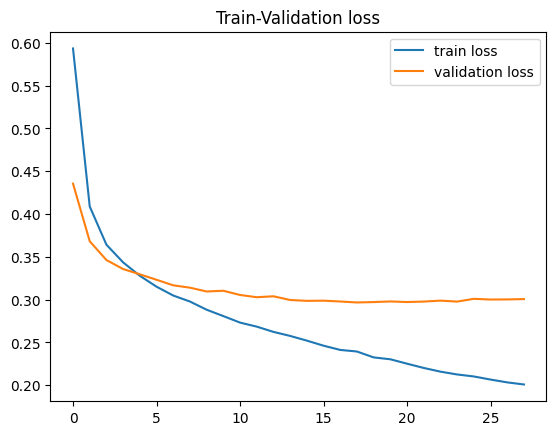

In [16]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [17]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8354591836734694, 'precision': 0.8354591836734694, 'f1': 0.8354591836734694, 'accuracy': 0.8354591836734694}
MALE {'recall': 0.8229166666666666, 'precision': 0.8229166666666666, 'f1': 0.8229166666666666, 'accuracy': 0.8229166666666666}
FEMALE {'recall': 0.8475, 'precision': 0.8475, 'f1': 0.8475, 'accuracy': 0.8475} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6553030303030303, 'precision': 0.6553030303030303, 'f1': 0.6553030303030303, 'accuracy': 0.6553030303030303}
MALE {'recall': 0.6472019464720195, 'precision': 0.6472019464720195, 'f1': 0.6472019464720195, 'accuracy': 0.6472019464720195}
FEMALE {'recall': 0.6640419947506562, 'precision': 0.6640419947506562, 'f1': 0.6640419947506562, 'accuracy': 0.6640419947506562} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6870925684485006, 'precision': 0.6870925684485006, 'f1': 0.6870925684485006, 'accuracy': 0.6870925684485006}
MALE {'recall': 

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5922376466233555 	 Validation loss: 0.4282627024893033 	 
  1%|          | 574/57400 [02:02<3:14:38,  4.87it/s]
Epoch 2 	 Training loss: 0.3985359774649351 	 Validation loss: 0.3584462687120599 	 
  2%|▏         | 1148/57400 [04:05<3:13:14,  4.85it/s]
Epoch 3 	 Training loss: 0.3560224689984571 	 Validation loss: 0.34091374480118186 	 
  3%|▎         | 1722/57400 [06:08<3:22:28,  4.58it/s]
Epoch 4 	 Training loss: 0.33637114603864193 	 Validation loss: 0.33074482719776993 	 
  4%|▍         | 2296/57400 [08:14<3:18:30,  4.63it/s]
Epoch 5 	 Training loss: 0.3241783041208463 	 Validation loss: 0.32358125609866645 	 
  5%|▌         | 2870/57400 [10:19<3:08:40,  4.82it/s]
Epoch 6 	 Training loss: 0.31081687246257833 	 Validation loss: 0.31767448530358783 	 
  6%|▌         | 3444/57400 [12:25<3:03:39,  4.90it/s]
Epoch 7 	 Training loss: 0.30282527317361135 	 Validation loss: 0.3129313232029899 	 
  7%|▋         | 4018/57400 [14:31<2:39:26,  5.58it/s]
Epoch 8 	 Trai

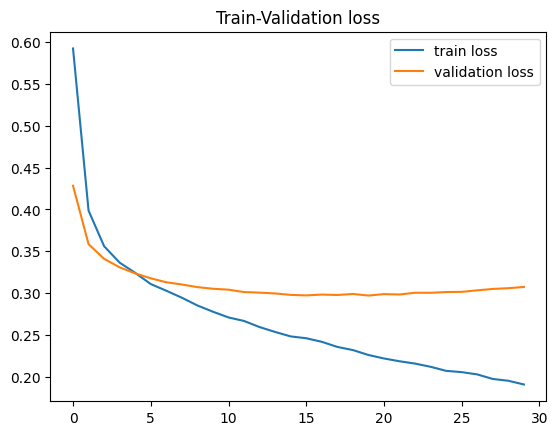

In [18]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8380102040816326, 'precision': 0.8380102040816326, 'f1': 0.8380102040816326, 'accuracy': 0.8380102040816326}
MALE {'recall': 0.8229166666666666, 'precision': 0.8229166666666666, 'f1': 0.8229166666666666, 'accuracy': 0.8229166666666666}
FEMALE {'recall': 0.8525, 'precision': 0.8525, 'f1': 0.8525, 'accuracy': 0.8525} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6641414141414141, 'precision': 0.6641414141414141, 'f1': 0.6641414141414141, 'accuracy': 0.6641414141414141}
MALE {'recall': 0.6472019464720195, 'precision': 0.6472019464720195, 'f1': 0.6472019464720195, 'accuracy': 0.6472019464720195}
FEMALE {'recall': 0.6824146981627297, 'precision': 0.6824146981627297, 'f1': 0.6824146981627297, 'accuracy': 0.6824146981627297} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.681877444589309, 'precision': 0.681877444589309, 'f1': 0.681877444589309, 'accuracy': 0.681877444589309}
MALE {'recall': 0.63

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5703205402927531 	 Validation loss: 0.4281351349111331 	 
  1%|          | 574/57400 [02:01<3:14:29,  4.87it/s]
Epoch 2 	 Training loss: 0.395687094496933 	 Validation loss: 0.3608892676183733 	 
  2%|▏         | 1148/57400 [04:03<2:40:18,  5.85it/s]
Epoch 3 	 Training loss: 0.35416240795460313 	 Validation loss: 0.3436599747609284 	 
  3%|▎         | 1722/57400 [06:05<3:18:09,  4.68it/s]
Epoch 4 	 Training loss: 0.3339098344333081 	 Validation loss: 0.3309959178253756 	 
  4%|▍         | 2296/57400 [08:07<3:10:41,  4.82it/s]
Epoch 5 	 Training loss: 0.32055001851262116 	 Validation loss: 0.32525798375323667 	 
  5%|▌         | 2870/57400 [10:09<3:07:59,  4.83it/s]
Epoch 6 	 Training loss: 0.3072027438401345 	 Validation loss: 0.3194322831044763 	 
  6%|▌         | 3444/57400 [12:11<3:11:10,  4.70it/s]
Epoch 7 	 Training loss: 0.29803110607202044 	 Validation loss: 0.3145650794445458 	 
  7%|▋         | 4018/57400 [14:13<3:08:48,  4.71it/s]
Epoch 8 	 Training

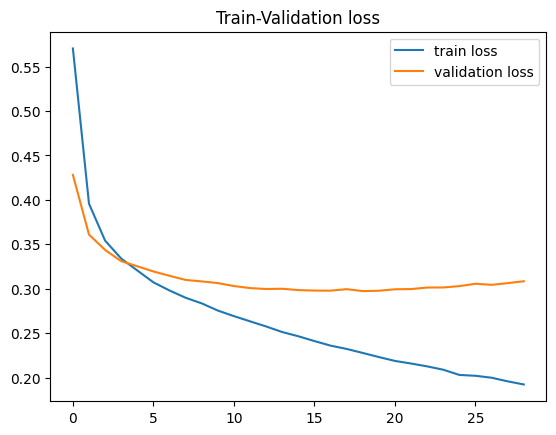

In [20]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [21]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.826530612244898, 'precision': 0.826530612244898, 'f1': 0.826530612244898, 'accuracy': 0.826530612244898}
MALE {'recall': 0.8177083333333334, 'precision': 0.8177083333333334, 'f1': 0.8177083333333333, 'accuracy': 0.8177083333333334}
FEMALE {'recall': 0.835, 'precision': 0.835, 'f1': 0.835, 'accuracy': 0.835} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6565656565656566, 'precision': 0.6565656565656566, 'f1': 0.6565656565656566, 'accuracy': 0.6565656565656566}
MALE {'recall': 0.6520681265206812, 'precision': 0.6520681265206812, 'f1': 0.6520681265206812, 'accuracy': 0.6520681265206812}
FEMALE {'recall': 0.6614173228346457, 'precision': 0.6614173228346457, 'f1': 0.6614173228346457, 'accuracy': 0.6614173228346457} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6897001303780965, 'precision': 0.6897001303780965, 'f1': 0.6897001303780965, 'accuracy': 0.6897001303780965}
MALE {'recall': 0.648989

Resultados finales

In [22]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8333333333333334, 'precision': 0.8333333333333334, 'f1': 0.8333333333333334, 'accuracy': 0.8333333333333334}
Métricas etiqueta male: {'recall': 0.8211805555555556, 'precision': 0.8211805555555556, 'f1': 0.8211805555555555, 'accuracy': 0.8211805555555556}
Métricas etiqueta female:  {'recall': 0.845, 'precision': 0.845, 'f1': 0.845, 'accuracy': 0.845}

 to
Resultado global: {'recall': 0.6586700336700336, 'precision': 0.6586700336700336, 'f1': 0.6586700336700336, 'accuracy': 0.6586700336700336}
Métricas etiqueta male: {'recall': 0.64882400648824, 'precision': 0.64882400648824, 'f1': 0.64882400648824, 'accuracy': 0.64882400648824}
Métricas etiqueta female:  {'recall': 0.6692913385826772, 'precision': 0.6692913385826772, 'f1': 0.6692913385826772, 'accuracy': 0.6692913385826772}

 as
Resultado global: {'recall': 0.6862233811386353, 'precision': 0.6862233811386353, 'f1': 0.6862233811386353, 'accuracy': 0.6862233811386353}
Métricas et

# TO

In [23]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.69457219068597 	 Validation loss: 0.692772785485801 	 
  1%|          | 574/57400 [02:01<3:17:39,  4.79it/s]
Epoch 2 	 Training loss: 0.6938770071762365 	 Validation loss: 0.6922313560873775 	 
  2%|▏         | 1148/57400 [04:03<3:23:39,  4.60it/s]
Epoch 3 	 Training loss: 0.6934157442755815 	 Validation loss: 0.694313005875733 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [06:04<3:14:20,  4.77it/s]
Epoch 4 	 Training loss: 0.6930427728837375 	 Validation loss: 0.6934257028466564 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [08:06<2:38:16,  5.80it/s]
Epoch 5 	 Training loss: 0.6928880192884584 	 Validation loss: 0.6937057870929524 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [10:07<3:38:24,  4.16it/s]
Epoch 6 	 Training loss: 0.692821611510752 	 Validation loss: 0.6930449019044133 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [12:08<3:00:29,  4.98it/s]
Epoch 7 	 Training loss: 0.6925656772656723 	 Vali

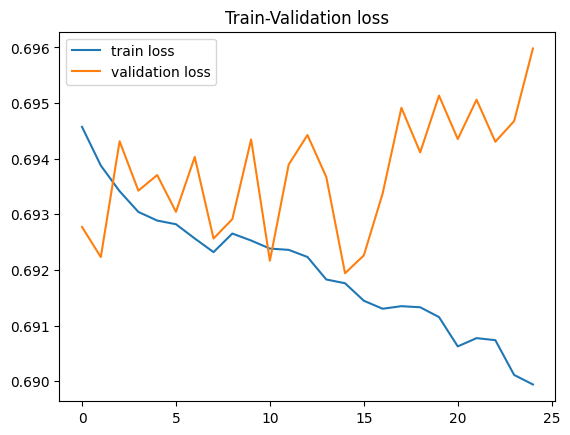

In [24]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [25]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5612244897959183, 'precision': 0.5612244897959183, 'f1': 0.5612244897959183, 'accuracy': 0.5612244897959183}
MALE {'recall': 0.3385416666666667, 'precision': 0.3385416666666667, 'f1': 0.3385416666666667, 'accuracy': 0.3385416666666667}
FEMALE {'recall': 0.775, 'precision': 0.775, 'f1': 0.775, 'accuracy': 0.775} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5656565656565656, 'precision': 0.5656565656565656, 'f1': 0.5656565656565656, 'accuracy': 0.5656565656565656}
MALE {'recall': 0.39416058394160586, 'precision': 0.39416058394160586, 'f1': 0.3941605839416059, 'accuracy': 0.39416058394160586}
FEMALE {'recall': 0.7506561679790026, 'precision': 0.7506561679790026, 'f1': 0.7506561679790026, 'accuracy': 0.7506561679790026} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5658409387222947, 'precision': 0.5658409387222947, 'f1': 0.5658409387222947, 'accuracy': 0.5658409387222947}
MALE {'recall': 0

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6961323453781912 	 Validation loss: 0.6928265589778706 	 
  1%|          | 574/57400 [02:01<3:14:34,  4.87it/s]
Epoch 2 	 Training loss: 0.6959120583451168 	 Validation loss: 0.6921116012637898 	 
  2%|▏         | 1148/57400 [04:03<3:17:12,  4.75it/s]
Epoch 3 	 Training loss: 0.6954425680305069 	 Validation loss: 0.6922590783086874 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [06:05<3:19:57,  4.64it/s]
Epoch 4 	 Training loss: 0.6950923619785375 	 Validation loss: 0.6936546139797922 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [08:07<3:04:39,  4.97it/s]
Epoch 5 	 Training loss: 0.6946338315458663 	 Validation loss: 0.6947972602763418 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [10:08<2:38:45,  5.72it/s]
Epoch 6 	 Training loss: 0.6943862359282862 	 Validation loss: 0.6921347601939056 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [12:09<2:34:18,  5.83it/s]
Epoch 7 	 Training loss: 0.6940377795945477 	

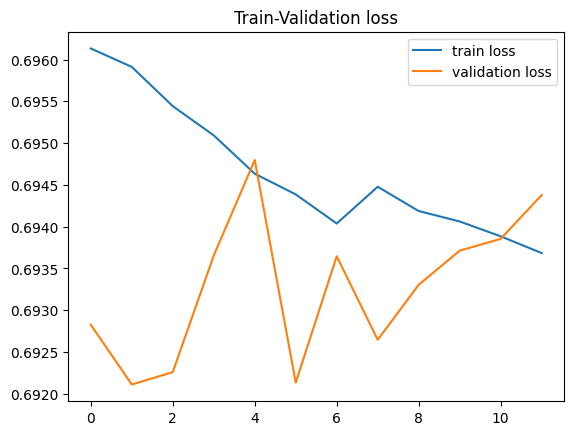

In [26]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_to2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.45790816326530615, 'precision': 0.45790816326530615, 'f1': 0.4579081632653062, 'accuracy': 0.45790816326530615}
MALE {'recall': 0.1953125, 'precision': 0.1953125, 'f1': 0.1953125, 'accuracy': 0.1953125}
FEMALE {'recall': 0.71, 'precision': 0.71, 'f1': 0.7100000000000001, 'accuracy': 0.71} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.43308080808080807, 'precision': 0.43308080808080807, 'f1': 0.43308080808080807, 'accuracy': 0.43308080808080807}
MALE {'recall': 0.22627737226277372, 'precision': 0.22627737226277372, 'f1': 0.22627737226277372, 'accuracy': 0.22627737226277372}
FEMALE {'recall': 0.6561679790026247, 'precision': 0.6561679790026247, 'f1': 0.6561679790026247, 'accuracy': 0.6561679790026247} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.4810951760104302}
MALE {'recall': 0.20707070707070707

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6951958392762971 	 Validation loss: 0.6927223912740158 	 
  1%|          | 574/57400 [02:01<3:21:21,  4.70it/s]
Epoch 2 	 Training loss: 0.6938128541986286 	 Validation loss: 0.6923011490854166 	 
  2%|▏         | 1148/57400 [04:03<3:20:13,  4.68it/s]
Epoch 3 	 Training loss: 0.6936890610626766 	 Validation loss: 0.6920328948457363 	 
  3%|▎         | 1722/57400 [06:05<3:19:07,  4.66it/s]
Epoch 4 	 Training loss: 0.6934165009638158 	 Validation loss: 0.6925707621089483 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [08:06<3:06:18,  4.93it/s]
Epoch 5 	 Training loss: 0.6932545882691905 	 Validation loss: 0.6929935085571418 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [10:08<3:12:26,  4.72it/s]
Epoch 6 	 Training loss: 0.6930694260248323 	 Validation loss: 0.6932542303861198 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [12:10<3:04:23,  4.88it/s]
Epoch 7 	 Training loss: 0.6930119769083083 	 Validation loss: 0.692170565

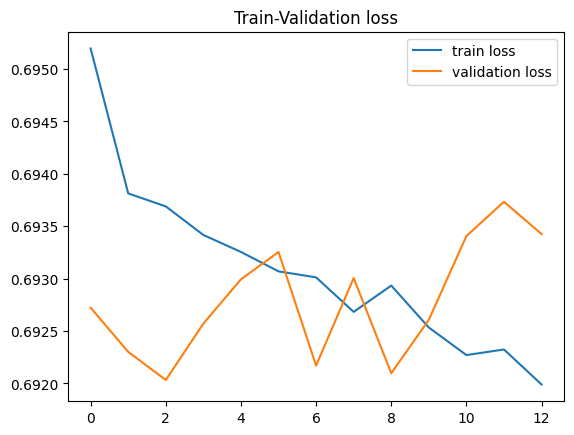

In [28]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_to3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5165816326530612, 'precision': 0.5165816326530612, 'f1': 0.5165816326530612, 'accuracy': 0.5165816326530612}
MALE {'recall': 0.11197916666666667, 'precision': 0.11197916666666667, 'f1': 0.11197916666666667, 'accuracy': 0.11197916666666667}
FEMALE {'recall': 0.905, 'precision': 0.905, 'f1': 0.905, 'accuracy': 0.905} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5075757575757576, 'precision': 0.5075757575757576, 'f1': 0.5075757575757576, 'accuracy': 0.5075757575757576}
MALE {'recall': 0.15571776155717762, 'precision': 0.15571776155717762, 'f1': 0.15571776155717762, 'accuracy': 0.15571776155717762}
FEMALE {'recall': 0.8871391076115486, 'precision': 0.8871391076115486, 'f1': 0.8871391076115486, 'accuracy': 0.8871391076115486} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.47979139504563234, 'precision': 0.47979139504563234, 'f1': 0.47979139504563234, 'accuracy': 0.47979139504563234}
MALE {'r

Resultados finales

In [30]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5119047619047619, 'precision': 0.5119047619047619, 'f1': 0.5119047619047619, 'accuracy': 0.5119047619047619}
Métricas etiqueta male: {'recall': 0.2152777777777778, 'precision': 0.2152777777777778, 'f1': 0.2152777777777778, 'accuracy': 0.2152777777777778}
Métricas etiqueta female:  {'recall': 0.7966666666666666, 'precision': 0.7966666666666666, 'f1': 0.7966666666666667, 'accuracy': 0.7966666666666666}

 to
Resultado global: {'recall': 0.502104377104377, 'precision': 0.502104377104377, 'f1': 0.502104377104377, 'accuracy': 0.502104377104377}
Métricas etiqueta male: {'recall': 0.2587185725871857, 'precision': 0.2587185725871857, 'f1': 0.2587185725871858, 'accuracy': 0.2587185725871857}
Métricas etiqueta female:  {'recall': 0.7646544181977253, 'precision': 0.7646544181977253, 'f1': 0.7646544181977253, 'accuracy': 0.7646544181977253}

 as
Resultado global: {'recall': 0.5089091699261191, 'precision': 0.5089091699261191, 'f1': 0.50890

# AS

In [31]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.695565301574481 	 Validation loss: 0.6931176518989821 	 
  1%|          | 574/57400 [02:02<3:22:24,  4.68it/s]
Epoch 2 	 Training loss: 0.6941370242356423 	 Validation loss: 0.691710361989878 	 
  2%|▏         | 1148/57400 [04:04<3:17:45,  4.74it/s]
Epoch 3 	 Training loss: 0.693175044313125 	 Validation loss: 0.6915376317703118 	 
  3%|▎         | 1722/57400 [06:06<3:10:18,  4.88it/s]
Epoch 4 	 Training loss: 0.6916165594855253 	 Validation loss: 0.6896023134053764 	 
  4%|▍         | 2296/57400 [08:08<3:15:04,  4.71it/s]
Epoch 5 	 Training loss: 0.6896258163742903 	 Validation loss: 0.6923156986802311 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [10:09<3:07:37,  4.84it/s]
Epoch 6 	 Training loss: 0.6882156366255225 	 Validation loss: 0.6901626627323991 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [12:11<2:31:20,  5.94it/s]
Epoch 7 	 Training loss: 0.6875607076422263 	 Validation loss: 0.6939112655187057 	 

3 epoch without impr

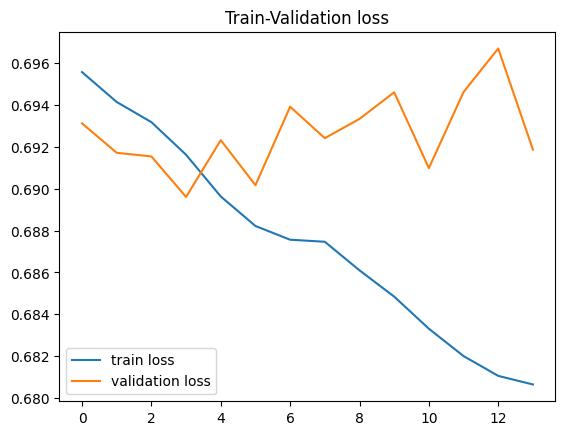

In [32]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_as'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [33]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5191326530612245, 'precision': 0.5191326530612245, 'f1': 0.5191326530612245, 'accuracy': 0.5191326530612245}
MALE {'recall': 0.28125, 'precision': 0.28125, 'f1': 0.28125, 'accuracy': 0.28125}
FEMALE {'recall': 0.7475, 'precision': 0.7475, 'f1': 0.7475, 'accuracy': 0.7475} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.523989898989899, 'precision': 0.523989898989899, 'f1': 0.523989898989899, 'accuracy': 0.523989898989899}
MALE {'recall': 0.31873479318734793, 'precision': 0.31873479318734793, 'f1': 0.31873479318734793, 'accuracy': 0.31873479318734793}
FEMALE {'recall': 0.7454068241469817, 'precision': 0.7454068241469817, 'f1': 0.7454068241469817, 'accuracy': 0.7454068241469817} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.546284224250326, 'precision': 0.546284224250326, 'f1': 0.546284224250326, 'accuracy': 0.546284224250326}
MALE {'recall': 0.30303030303030304, 'precision': 0.303030303030

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6948105794627492 	 Validation loss: 0.6924515295836885 	 
  1%|          | 574/57400 [02:02<2:42:27,  5.83it/s]
Epoch 2 	 Training loss: 0.6935874906981864 	 Validation loss: 0.6926774938227767 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:03<3:16:51,  4.76it/s]
Epoch 3 	 Training loss: 0.692456146046675 	 Validation loss: 0.6921299120127145 	 
  3%|▎         | 1722/57400 [06:05<3:06:32,  4.97it/s]
Epoch 4 	 Training loss: 0.6908237036927651 	 Validation loss: 0.6913859399698549 	 
  4%|▍         | 2296/57400 [08:07<3:16:02,  4.68it/s]
Epoch 5 	 Training loss: 0.6888968754520814 	 Validation loss: 0.6899145003092491 	 
  5%|▌         | 2870/57400 [10:09<3:07:31,  4.85it/s]
Epoch 6 	 Training loss: 0.688348872113311 	 Validation loss: 0.6915755746728283 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [12:11<3:03:45,  4.89it/s]
Epoch 7 	 Training loss: 0.6877232481585978 	 Validation loss: 0.6922371973425655 	 

2 epoch without imp

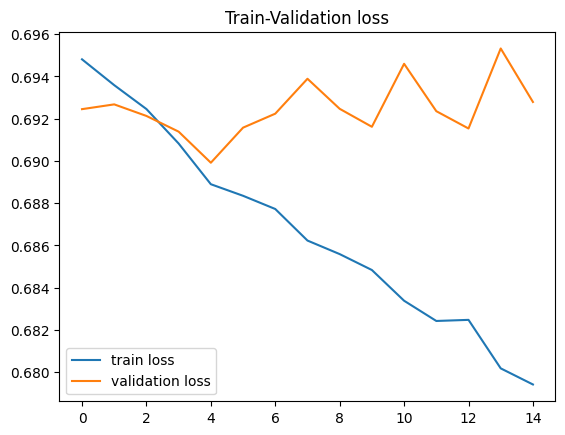

In [34]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_as2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5471938775510204, 'precision': 0.5471938775510204, 'f1': 0.5471938775510204, 'accuracy': 0.5471938775510204}
MALE {'recall': 0.2864583333333333, 'precision': 0.2864583333333333, 'f1': 0.2864583333333333, 'accuracy': 0.2864583333333333}
FEMALE {'recall': 0.7975, 'precision': 0.7975, 'f1': 0.7975, 'accuracy': 0.7975} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5542929292929293, 'precision': 0.5542929292929293, 'f1': 0.5542929292929293, 'accuracy': 0.5542929292929293}
MALE {'recall': 0.3357664233576642, 'precision': 0.3357664233576642, 'f1': 0.3357664233576642, 'accuracy': 0.3357664233576642}
FEMALE {'recall': 0.7900262467191601, 'precision': 0.7900262467191601, 'f1': 0.7900262467191601, 'accuracy': 0.7900262467191601} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5814863102998696, 'precision': 0.5814863102998696, 'f1': 0.5814863102998696, 'accuracy': 0.5814863102998696}
MALE {'recall': 

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6941057783178336 	 Validation loss: 0.6925358459100885 	 
  1%|          | 574/57400 [02:01<3:21:56,  4.69it/s]
Epoch 2 	 Training loss: 0.6934171524612746 	 Validation loss: 0.692683107772116 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:03<3:08:23,  4.98it/s]
Epoch 3 	 Training loss: 0.6922352267266981 	 Validation loss: 0.6926988433983366 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [06:05<2:35:01,  5.99it/s]
Epoch 4 	 Training loss: 0.6912245482517867 	 Validation loss: 0.6908604947187132 	 
  4%|▍         | 2296/57400 [08:06<2:35:06,  5.92it/s]
Epoch 5 	 Training loss: 0.6895199073316328 	 Validation loss: 0.6910434557219683 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [10:08<3:09:59,  4.78it/s]
Epoch 6 	 Training loss: 0.6888346227619291 	 Validation loss: 0.6895436402094566 	 
  6%|▌         | 3444/57400 [12:10<3:38:34,  4.11it/s]
Epoch 7 	 Training loss: 0.6872098549733179 	 Validation loss: 0.6909869646

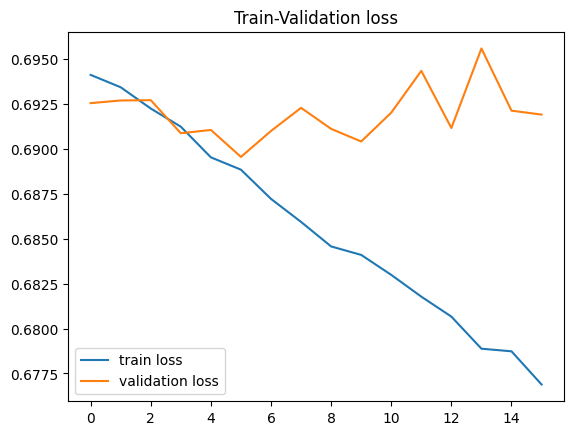

In [36]:
model = st.SingleTaskSimple(model_conf).to(device)
save_path='simple_distilbert_as3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = st.SingleTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5918367346938775, 'precision': 0.5918367346938775, 'f1': 0.5918367346938775, 'accuracy': 0.5918367346938775}
MALE {'recall': 0.5651041666666666, 'precision': 0.5651041666666666, 'f1': 0.5651041666666666, 'accuracy': 0.5651041666666666}
FEMALE {'recall': 0.6175, 'precision': 0.6175, 'f1': 0.6175, 'accuracy': 0.6175} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6161616161616161, 'precision': 0.6161616161616161, 'f1': 0.6161616161616161, 'accuracy': 0.6161616161616161}
MALE {'recall': 0.5912408759124088, 'precision': 0.5912408759124088, 'f1': 0.5912408759124088, 'accuracy': 0.5912408759124088}
FEMALE {'recall': 0.6430446194225722, 'precision': 0.6430446194225722, 'f1': 0.6430446194225722, 'accuracy': 0.6430446194225722} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6232073011734028, 'precision': 0.6232073011734028, 'f1': 0.6232073011734028, 'accuracy': 0.6232073011734028}
MALE {'recall': 

Resultados finales

In [38]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5527210884353742, 'precision': 0.5527210884353742, 'f1': 0.5527210884353742, 'accuracy': 0.5527210884353742}
Métricas etiqueta male: {'recall': 0.37760416666666663, 'precision': 0.37760416666666663, 'f1': 0.37760416666666663, 'accuracy': 0.37760416666666663}
Métricas etiqueta female:  {'recall': 0.7208333333333333, 'precision': 0.7208333333333333, 'f1': 0.7208333333333333, 'accuracy': 0.7208333333333333}

 to
Resultado global: {'recall': 0.5648148148148148, 'precision': 0.5648148148148148, 'f1': 0.5648148148148148, 'accuracy': 0.5648148148148148}
Métricas etiqueta male: {'recall': 0.41524736415247365, 'precision': 0.41524736415247365, 'f1': 0.41524736415247365, 'accuracy': 0.41524736415247365}
Métricas etiqueta female:  {'recall': 0.726159230096238, 'precision': 0.726159230096238, 'f1': 0.726159230096238, 'accuracy': 0.726159230096238}

 as
Resultado global: {'recall': 0.5836592785745328, 'precision': 0.5836592785745328, 'f1':